In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_scheduler.scheduler.utils import SkyAreaGenerator
import sqlite3
from astropy.time import Time

import sys
sys.path.append("./")
from qso_number_counts_metric_mag import QSONumberCountsMetric_gdli

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_time_range(baseline):
    """
    Query the baseline database to get the observation time range.

    Parameters:
    baseline (str): Path to the baseline database file.

    Returns:
    tuple: Start and end MJD of observations.
    """
    conn = sqlite3.connect(baseline)
    cursor = conn.cursor()
    
    query = "SELECT MIN(observationStartMJD), MAX(observationStartMJD) FROM observations"
    cursor.execute(query)
    result = cursor.fetchone()
    
    conn.close()
    
    return result

baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
start_mjd, end_mjd = get_time_range(baseline)
start_date = Time(start_mjd, format='mjd').to_value('iso', subfmt='date')
end_date = Time(end_mjd, format='mjd').to_value('iso', subfmt='date')

# Calculate the difference in years
start_time = Time(start_mjd, format='mjd')
end_time = Time(end_mjd, format='mjd')
difference_in_years = (end_time - start_time).to('year')

print(f"Start MJD: {start_mjd}, End MJD: {end_mjd}")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Difference in Years: {difference_in_years:.2f}")

Start MJD: 60796.00143922635, End MJD: 64448.42922491617
Start Date: 2025-05-01
End Date: 2035-05-01
Difference in Years: 10.00 yr


/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [4]:
def calculate_qso_numbers(baseline, nside, maps, outdir, ourdir_db):
    """
    Calculate QSO numbers for different filters and redshifts.

    Parameters:
    baseline (str): Path to the baseline database file.
    nside (int): HEALPix resolution parameter.
    maps (array): Array of HEALPix IDs to use.
    outdir (str): Output directory for results.
    ourdir_db (str): Directory for results database.

    Returns:
    dict: Dictionary of metric bundles for each filter, redshift, and month.
    """
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    
    bundles = {}
    dustmap = maf.DustMap(nside=nside)
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        metric = maf.QSONumberCountsMetric(f, zmax=6.7)
        #sql = f'target_name not like "DD%" and filter = "{f}"'
        sql = f'filter = "{f}"'
        bundle = maf.MetricBundle(metric, slicer, sql, run_name=run_name, maps_list=[dustmap], info_label=f'{f} band')
        bundles[f] = bundle

    results_db = maf.db.ResultsDb(out_dir=ourdir_db)
    bundle_group = maf.MetricBundleGroup(bundles, baseline_file, out_dir=outdir, results_db=results_db)
    bundle_group.run_all()
    return bundles

def calculate_total_qsos(bundles):
    """
    Calculate the total number of QSOs for each filter.

    Parameters:
    bundles (dict): Metric bundles for each filter.

    Returns:
    dict: Total number of QSOs for each filter.
    """
    total_qsos_per_band = {}
    summary = maf.SumMetric(col='metric', metric_name='Total QSO')
    
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        bundles[f].set_summary_metrics([summary])
        bundles[f].compute_summary_stats()
        total_qsos = bundles[f].summary_values['Total QSO']
        total_qsos_per_band[f] = total_qsos
        print(f'Total QSO count in {f} band: {total_qsos}')
    return total_qsos_per_band

def calculate_qso_numbers_mlim(baseline, nside, maps, outdir, ourdir_db):
    """
    Calculate QSO numbers for different filters and redshifts.

    Parameters:
    baseline (str): Path to the baseline database file.
    nside (int): HEALPix resolution parameter.
    maps (array): Array of HEALPix IDs to use.
    outdir (str): Output directory for results.
    ourdir_db (str): Directory for results database.

    Returns:
    dict: Dictionary of metric bundles for each filter, redshift, and month.
    """
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    annual_bundles = {m: {f: {} for f in ('u', 'g', 'r', 'i', 'z', 'y')} for m in range(15, 29)}
    
    dustmap = maf.DustMap(nside=nside)
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)
    
    for n in range(15, 29):
        print(f"Processing mag< {n}...")
        for f in ('u', 'g', 'r', 'i', 'z', 'y'):
            Redshift = np.arange(0.4, 6.8, 0.1)   
            for red in Redshift:
                metric = QSONumberCountsMetric_gdli(f, zmax=red, mlim=n)
                sql = f'target_name not like "DD%" and filter = "{f}" '
                bundle = maf.MetricBundle(metric, slicer, sql, run_name=f'{run_name}_mag{n}', maps_list=[dustmap], info_label=f'{f} band redshift {red:.1f} mag {n}')
                annual_bundles[n][f][red] = bundle
                
        results_db = maf.db.ResultsDb(out_dir=os.path.join(ourdir_db, f'{run_name}_mag{n}'))
        bundle_group = maf.MetricBundleGroup({f'{f}_z{red}': annual_bundles[n][f][red] for f in annual_bundles[n] for red in annual_bundles[n][f]}, baseline_file, out_dir=outdir, results_db=results_db)
        bundle_group.run_all()
    return annual_bundles

In [5]:
baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
nside = 64
outdir = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Output'
ourdir_db = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Output/'

# Generate survey areas
survey_areas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = survey_areas.return_maps()

# Select HEALPix IDs for specific regions
maps = np.where(
    (map_labels == 'LMC_SMC') |
    (map_labels == 'bulge') |
    (map_labels == 'dusty_plane') |
    (map_labels == '') |
    (map_labels == 'lowdust') |
    (map_labels == 'nes') |
    (map_labels == 'scp') |
    (map_labels == 'virgo')
)[0]

qso_numbers = calculate_qso_numbers(baseline, nside, maps, outdir, ourdir_db)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [6]:
baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
nside = 64
outdir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/Baseline_4_0_mz'
ourdir_db = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/Baseline_4_0_mz/MetricData/'


# Generate survey areas
survey_areas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = survey_areas.return_maps()

# Select HEALPix IDs for specific regions
maps = np.where(
    (map_labels == 'LMC_SMC') |
    (map_labels == 'bulge') |
    (map_labels == 'dusty_plane') |
    (map_labels == '') |
    (map_labels == 'lowdust') |
    (map_labels == 'nes') |
    (map_labels == 'scp') |
    (map_labels == 'virgo')
)[0]

qso_numbers = calculate_qso_numbers_mlim(baseline, nside, maps, outdir, ourdir_db)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Processing mag< 15...
Processing mag< 16...
Processing mag< 17...
Processing mag< 18...
Processing mag< 19...
Processing mag< 20...
Processing mag< 21...
Processing mag< 22...
Processing mag< 23...
Processing mag< 24...
Processing mag< 25...
Processing mag< 26...
Processing mag< 27...
Processing mag< 28...


In [9]:
from rubin_sim.maf import MetricBundle, MetricBundleGroup

def calculate_total_qsos_band(bundle):
    """
    Calculate the total number of QSOs for a given metric bundle.
    
    Parameters:
    bundle (MetricBundle): The metric bundle to calculate QSOs from.
    
    Returns:
    float: The total number of QSOs.
    """
    summary = maf.SumMetric(col='metric')
    bundle.set_summary_metrics([summary])
    bundle.compute_summary_stats()
    total_qsos = bundle.summary_values[summary.name]
    return total_qsos

def extract_qso_data(npz_file):
    """Extract QSO data from a .npz file."""
    bundle = MetricBundle.load(npz_file)
    total_qso = calculate_total_qsos_band(bundle)
    return int(total_qso)

def create_qso_csv_files(result_dir, output_dir, filters, redshift_range, months):
    """Create CSV files with QSO counts for each filter and year."""
    for f in filters:
        # Create a DataFrame to hold the results
        df = pd.DataFrame(index=[f"{z:.1f}" for z in redshift_range], columns=months)

        for month in months:
            for redshift in redshift_range:
                redshift_str = f"{redshift:.1f}".replace('.', '_')
                npz_file = os.path.join(result_dir, f"baseline_v4_0_10yrs_mag{month}_QSONumberCountsMetric_{f}_band_redshift_{redshift_str}_mag_{month}_HEAL.npz")
                
                if os.path.exists(npz_file):
                    qso_counts = extract_qso_data(npz_file)
                    # Assuming qso_counts is an array of QSO numbers, you might need to adjust this if it's a different structure
                    df.at[f"{redshift:.1f}", month] = qso_counts
                else:
                    df.at[f"{redshift:.1f}", month] = np.nan
        
        # Save DataFrame to CSV
        csv_file = os.path.join(output_dir, f"QSO_counts_mz_{f}.csv")
        df.to_csv(csv_file)
        print(f"Saved QSO counts to {csv_file}")

# Parameters
result_dir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/Baseline_4_0_mz'
output_dir = './' 
filters = ['u', 'g', 'r', 'i', 'z', 'y']
redshift_range = np.arange(0.4, 6.8, 0.1)
months = range(15, 29)

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate CSV files
create_qso_csv_files(result_dir, output_dir, filters, redshift_range, months)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

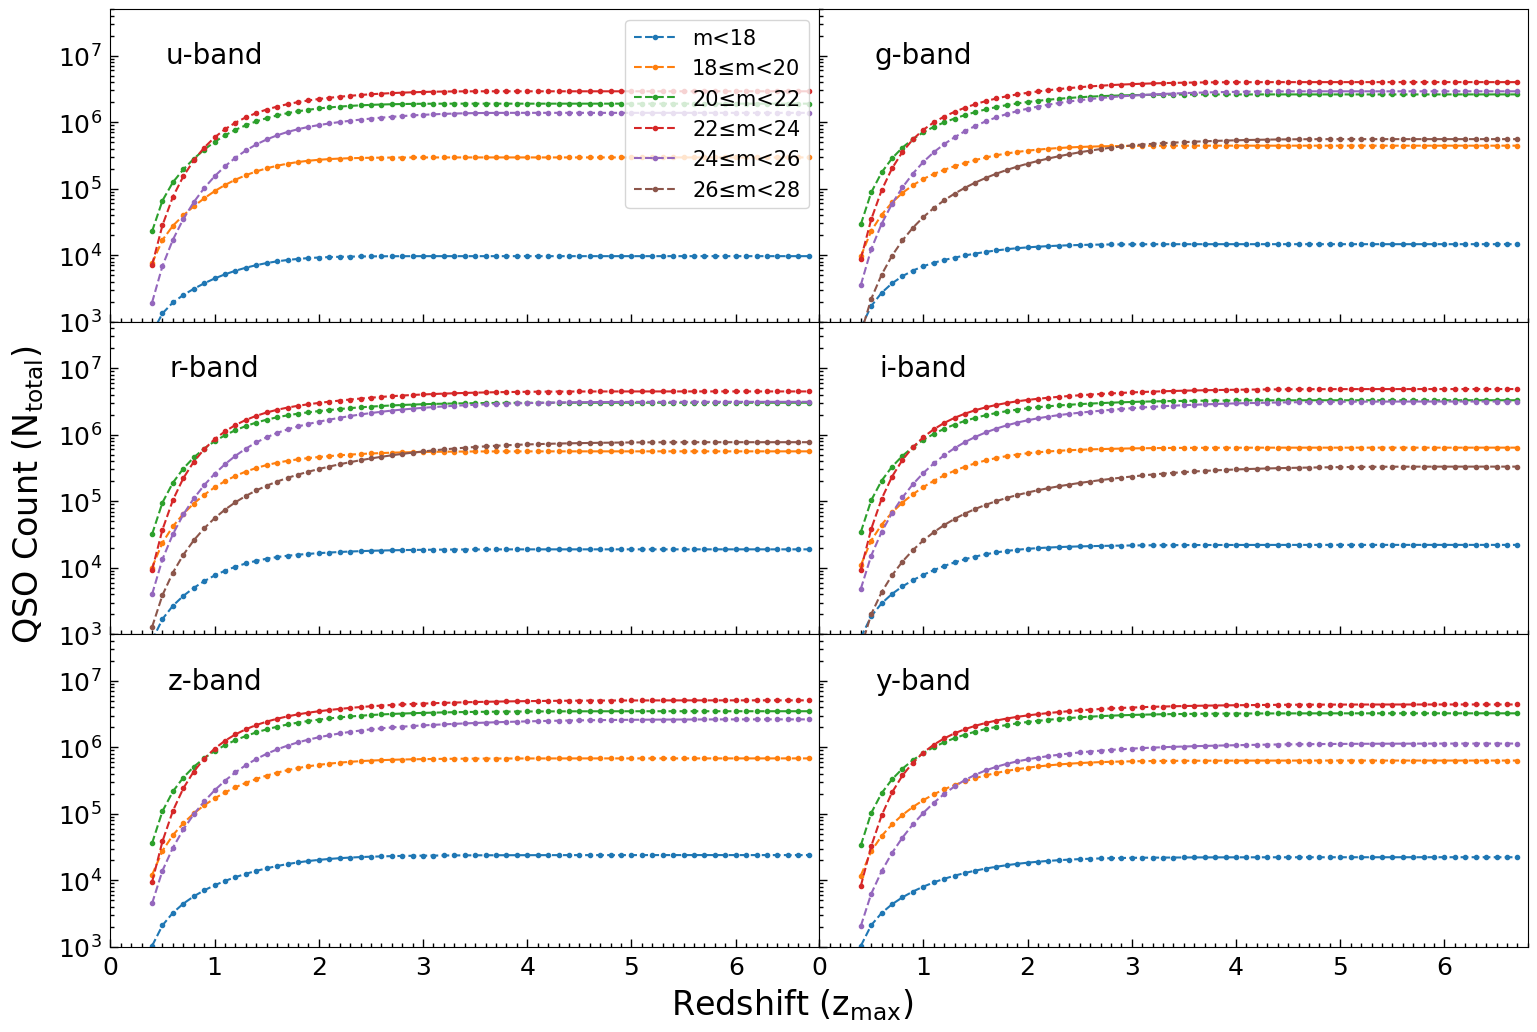

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


def plot_f4(ax,df,f):
    redshift_range = np.arange(0.4, 6.8, 0.1)
    #<18 18-20 20-22 22-24 24-26 26-28
    ax.plot(redshift_range, np.array(df['18']),  marker='o', linestyle='--',markersize=3,  label='m<18')
    ax.plot(redshift_range, np.array(df['20'])-np.array(df['18']),  marker='o', linestyle='--',markersize=3,  label='18≤m<20')
    ax.plot(redshift_range, np.array(df['22'])-np.array(df['20']),  marker='o', linestyle='--',markersize=3,  label='20≤m<22')
    ax.plot(redshift_range, np.array(df['24'])-np.array(df['22']),  marker='o', linestyle='--',markersize=3,  label='22≤m<24')
    ax.plot(redshift_range, np.array(df['26'])-np.array(df['24']),  marker='o', linestyle='--',markersize=3,  label='24≤m<26')
    if f=='u':
        ax.plot(redshift_range, 0*(np.array(df['28'])-np.array(df['26'])),  marker='o', linestyle='--',markersize=3, label='26≤m<28')
    elif f == 'g' or f=='r' or f=='i':
        ax.plot(redshift_range, np.array(df['28'])-np.array(df['26']),  marker='o', linestyle='--',markersize=3, label='26≤m<28')
    else:
        pass
    ax.set_yscale('log')
    ax.set_xlim(0,6.8)
    ax.set_ylim(1e3,5e7)
    xmajorLocator = MultipleLocator(1)
    xminorLocator = MultipleLocator(0.1)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=18,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    if f == 'u':
        ax.legend(loc='upper right', ncol=1, fontsize=15)
    ax.text(1, 1e7, f+'-band', fontsize=20, verticalalignment='center', horizontalalignment='center')

df_u = pd.read_csv('QSO_counts_mz_u.csv',index_col=0)
df_g = pd.read_csv('QSO_counts_mz_g.csv',index_col=0)
df_r = pd.read_csv('QSO_counts_mz_r.csv',index_col=0)
df_i = pd.read_csv('QSO_counts_mz_i.csv',index_col=0)
df_z = pd.read_csv('QSO_counts_mz_z.csv',index_col=0)
df_y = pd.read_csv('QSO_counts_mz_y.csv',index_col=0)
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex='col', sharey='row', 
                            gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
plot_f4(axs[0],df_u,f='u')
plot_f4(axs[1],df_g,f='g')
plot_f4(axs[2],df_r,f='r')
plot_f4(axs[3],df_i,f='i')
plot_f4(axs[4],df_z,f='z')
plot_f4(axs[5],df_y,f='y')
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, -0.01, r'Redshift ($\rm z_{max}$)', ha='center', va='center', fontsize=24)
fig.text(-0.01, 0.5, r'QSO Count ($\rm N_{total}$)', ha='center', va='center', rotation='vertical', fontsize=24)
plt.tight_layout()
plt.show()

In [11]:
df_u = pd.read_csv('QSO_counts_mz_u.csv',index_col=0)
df_g = pd.read_csv('QSO_counts_mz_g.csv',index_col=0)
df_r = pd.read_csv('QSO_counts_mz_r.csv',index_col=0)
df_i = pd.read_csv('QSO_counts_mz_i.csv',index_col=0)
df_z = pd.read_csv('QSO_counts_mz_z.csv',index_col=0)
df_y = pd.read_csv('QSO_counts_mz_y.csv',index_col=0)

/tmp/ipykernel_774/2434322459.py:41: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


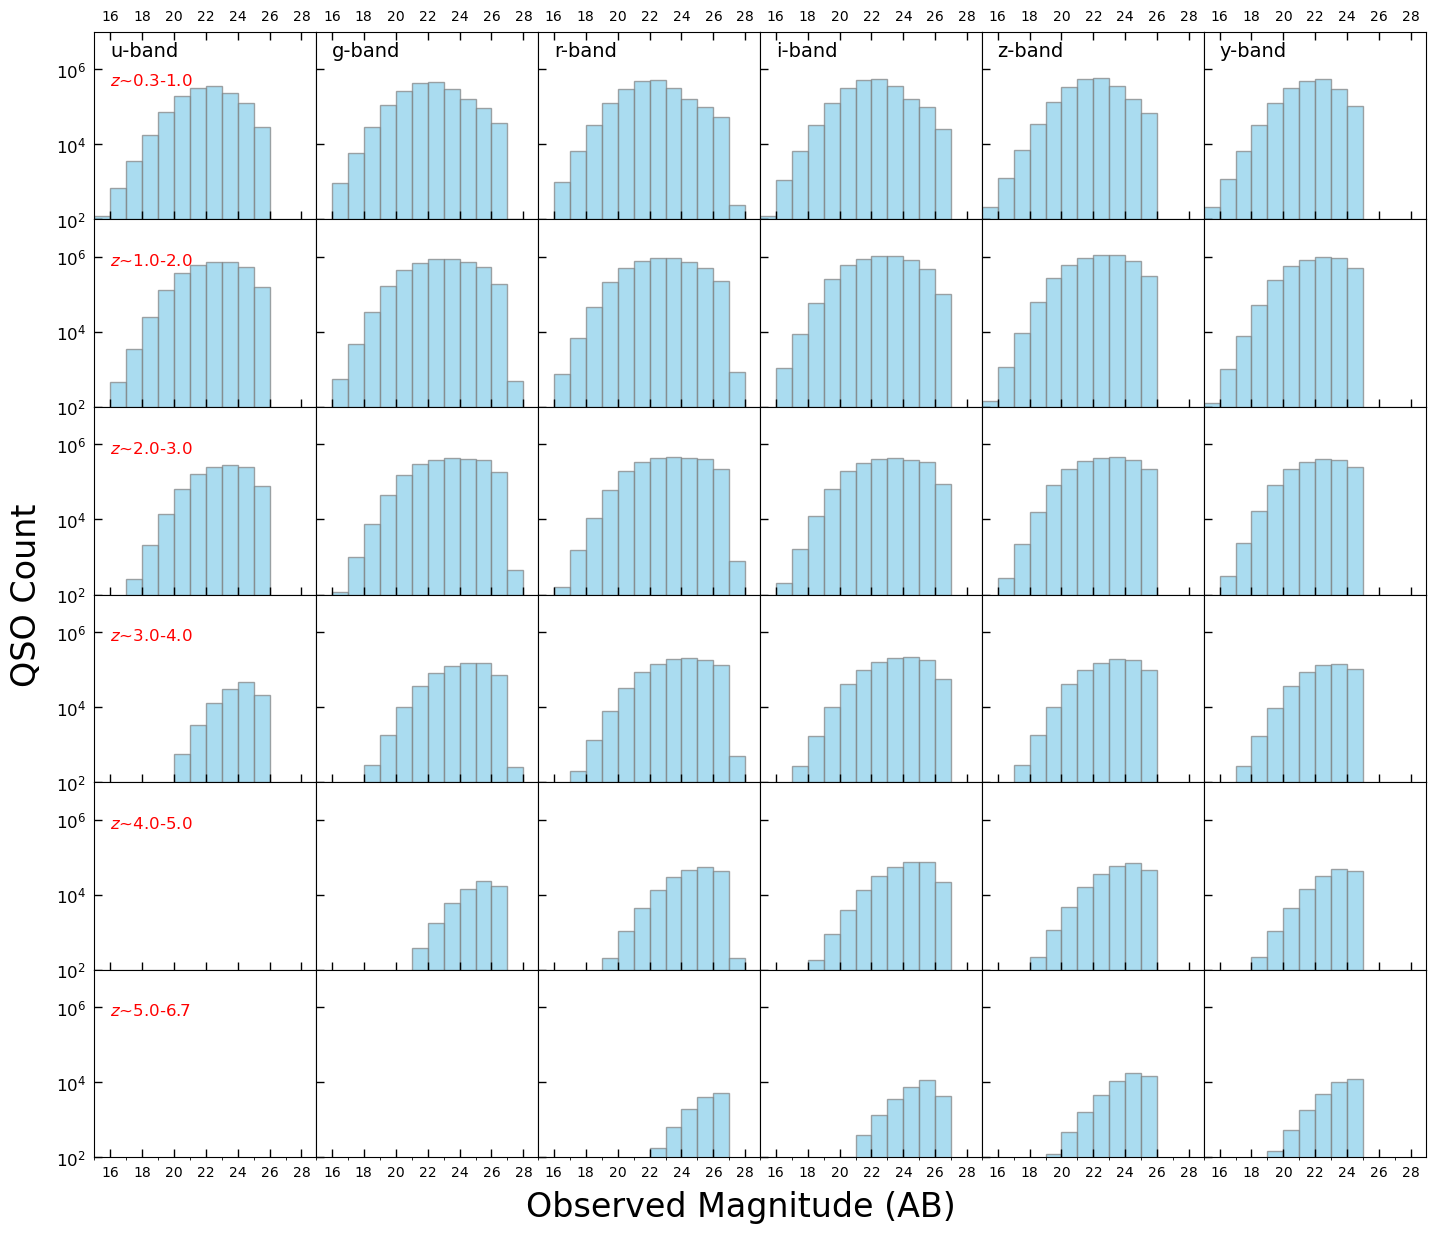

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def return_hist(df):
    redshift_range = np.arange(0.4, 6.8, 0.1)
    ma = np.arange(15, 29, 1)
    redshift_conditions = [
                            redshift_range < 1,
                            (redshift_range >= 1) & (redshift_range < 2),
                            (redshift_range >= 2) & (redshift_range < 3),
                            (redshift_range >= 3) & (redshift_range < 4),
                            (redshift_range >= 4) & (redshift_range < 5),
                            (redshift_range >= 5) & (redshift_range < 7),
                            ]
    
    results = [[] for _ in range(6)]
    
    for i in range(len(ma) - 1):
        line = np.array(df[str(ma[i + 1])]) - np.array(df[str(ma[i])])
        for idx, condition in enumerate(redshift_conditions):
            if idx == 0:
                results[idx].append(line[condition][-1])  # 第一个红移段取最后一个点
            else:
                results[idx].append(line[condition][-1] - line[condition][0])  # 其他段取差值
    return results

def plot(data, ax):
    a = np.arange(15, 28, 1)
    b = np.arange(16, 29, 1)
    x = (a + b) / 2
    ax.bar(
            x=x,
            height=data,
            width=1.0,
            align="center",
            alpha=0.7,
            color="skyblue",
            edgecolor="gray",
        )
    ax.set_xlim(15,28.9)
    ax.set_yscale('log')
    xmajorLocator = MultipleLocator(2)
    xminorLocator = MultipleLocator(1)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)

r_u, r_g, r_r, r_i, r_z, r_y = return_hist(df_u),return_hist(df_g),return_hist(df_r),\
                               return_hist(df_i),return_hist(df_z),return_hist(df_y)

fig, axs = plt.subplots(6, 6, figsize=(14, 12), sharex='col', sharey='row', 
                            gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
m=0
f = ['u', 'g', 'r', 'i', 'z', 'y']
for data in [r_u[0], r_g[0], r_r[0], r_i[0], r_z[0], r_y[0]]:
    zmin=0.3
    zmax=1.0
    plot(data, axs[m])
    axs[m].set_ylim(1e2,1e7)
    axs[m].tick_params(axis='y',which='major',tickdir='in',labelsize=12,width=1,pad=6,length=6,bottom=False, top=False, left=True, right=False)
    axs[m].text(16, 3e6, f[m]+'-band', fontsize=14, verticalalignment='center', horizontalalignment='left')
    axs[m].tick_params(axis='x',which='major',tickdir='in',labelsize=10,labeltop=True, labelbottom=False, width=1,pad=6,length=6,bottom=True, top=True, left=True, right=False)
    m=m+1

axs[0].text(16, 5e5, r'$z$~0.3-1.0', fontsize=12, verticalalignment='center', horizontalalignment='left', color='r')
axs[m].text(16, 8e5, r'$z$~1.0-2.0', fontsize=12, verticalalignment='center', horizontalalignment='left', color='r')
for data in [r_u[1], r_g[1], r_r[1], r_i[1], r_z[1], r_y[1]]:
    zmin=1.0
    zmax=2.0
    plot(data, axs[m])
    axs[m].set_ylim(1e2,1e7)
    axs[m].tick_params(axis='x',which='major',tickdir='in',labelsize=10,labeltop=False, labelbottom=False, width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    axs[m].tick_params(axis='y',which='major',tickdir='in',labelsize=12,width=1,pad=6,length=6,bottom=False, top=False, left=True, right=False)
    m=m+1    

axs[m].text(16, 8e5, r'$z$~2.0-3.0', fontsize=12, verticalalignment='center', horizontalalignment='left', color='r')
for data in [r_u[2], r_g[2], r_r[2], r_i[2], r_z[2], r_y[2]]:
    zmin=2.0
    zmax=3.0
    plot(data, axs[m])
    axs[m].set_ylim(1e2,1e7)
    axs[m].tick_params(axis='x',which='major',tickdir='in',labelsize=10,labeltop=False, labelbottom=False, width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    axs[m].tick_params(axis='y',which='major',tickdir='in',labelsize=12,width=1,pad=6,length=6,bottom=False, top=False, left=True, right=False)
    m=m+1 

axs[m].text(16, 8e5, r'$z$~3.0-4.0', fontsize=12, verticalalignment='center', horizontalalignment='left', color='r')
for data in [r_u[3], r_g[3], r_r[3], r_i[3], r_z[3], r_y[3]]:
    zmin=3.0
    zmax=4.0
    plot(data, axs[m])
    axs[m].set_ylim(1e2,1e7)
    axs[m].tick_params(axis='x',which='major',tickdir='in',labelsize=10,labeltop=False, labelbottom=False, width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    axs[m].tick_params(axis='y',which='major',tickdir='in',labelsize=12,width=1,pad=6,length=6,bottom=False, top=False, left=True, right=False)
    m=m+1 

axs[m].text(16, 8e5, r'$z$~4.0-5.0', fontsize=12, verticalalignment='center', horizontalalignment='left', color='r')
for data in [r_u[4], r_g[4], r_r[4], r_i[4], r_z[4], r_y[4]]:
    zmin=4.0
    zmax=5.0
    plot(data, axs[m])
    axs[m].set_ylim(1e2,1e7)
    axs[m].tick_params(axis='x',which='major',tickdir='in',labelsize=10,labeltop=False, labelbottom=False, width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    axs[m].tick_params(axis='y',which='major',tickdir='in',labelsize=12,width=1,pad=6,length=6,bottom=False, top=False, left=True, right=False)
    m=m+1 

axs[m].text(16, 8e5, r'$z$~5.0-6.7', fontsize=12, verticalalignment='center', horizontalalignment='left', color='r')
for data in [r_u[5], r_g[5], r_r[5], r_i[5], r_z[5], r_y[5]]:
    zmin=5.0
    zmax=6.7
    plot(data, axs[m])
    axs[m].set_ylim(1e2,1e7)
    #axs[m].tick_params(axis='y',which='major',tickdir='in',labelsize=12,width=1,pad=6,length=6,bottom=False, top=False, left=True, right=False)
    #axs[m].tick_params(axis='both',which='minor',tickdir='in',width=1,length=6,bottom=True, top=False, left=True, right=False)
    #axs[m].tick_params(axis='x',which='major',tickdir='in',labelsize=10,labelbottom=True, width=1,pad=6,length=6,bottom=False, top=False, left=True, right=False)
    axs[m].tick_params(axis='x',which='major',tickdir='in',labelsize=10,labeltop=False, labelbottom=True, width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    axs[m].tick_params(axis='y',which='major',tickdir='in',labelsize=12,width=1,pad=6,length=6,bottom=False, top=False, left=True, right=False)
    m=m+1 

plt.subplots_adjust(wspace=0, hspace=0)
#fig.text(0.5, -0.01, r'Redshift ($\rm z_{max}$)', ha='center', va='center', fontsize=24)
fig.text(0.5, -0.01, r'Observed Magnitude (AB)', ha='center', va='center', fontsize=24)
fig.text(-0.01, 0.5, r'QSO Count', ha='center', va='center', rotation='vertical', fontsize=24)
plt.tight_layout()
plt.savefig('Figure5.png', dpi=300, bbox_inches='tight')
plt.show()